In [2]:
from PIL import Image
import numpy as np
import re
import cv2
import pandas as pd

import os
from google.cloud import vision

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"..\keys\pythonreceipts-43e91022a1fa.json"
client = vision.ImageAnnotatorClient()

In [3]:
def plot_results(image, mode="inline", scale=0.6):
    # Display the result
    if mode == "popup":
        pass
    elif mode == "inline":
        # Convert from BGR to RGB (because OpenCV uses BGR order for color channels, whereas PIL uses RGB.)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image_rgb)
    else:
        raise ValueError("Mode must be either 'popup' or 'inline'")

    if type(image) is np.ndarray:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        width, height = image.size
        display(image.resize((int(width*scale), int(height*scale))))

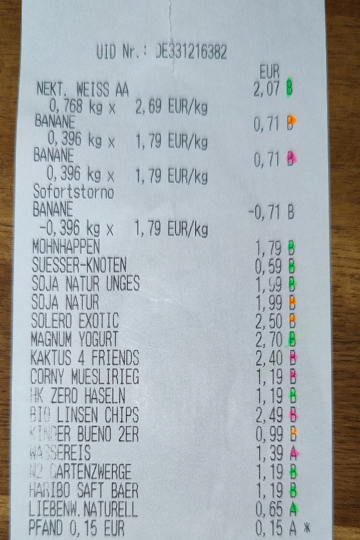

In [4]:
file_name_load = "2023-08-01_21-00"
image_path = f"../receipts/raw/{file_name_load}.jpg"
# image_path = "receipts/2023-09-30_18-16.jpg"
# image_path = "receipts/2023-08-14_12-33.jpg"
# image_path = "receipts/2023-08-09_21-26.jpg"
# TODO why not original coloration?
raw_image = cv2.imread(image_path)#[:,:,0]
raw_image = cv2.resize(raw_image, (720, 1080))
plot_results(raw_image, scale=0.5)

hsv_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2HSV)
# plot_results(hsv_image, scale=0.1)

In [5]:
## set color to detect
## green
lower = np.array([30, 50, 20])
upper = np.array([90, 255, 255])
## orange
# lower = np.array([10, 50, 20])
# upper = np.array([30, 255, 255])
## pink
# lower = np.array([130, 50, 20])
# upper = np.array([170, 255, 255])

20 23
19 25
20 26
20 25
24 36
19 27
17 23
17 23
14 43


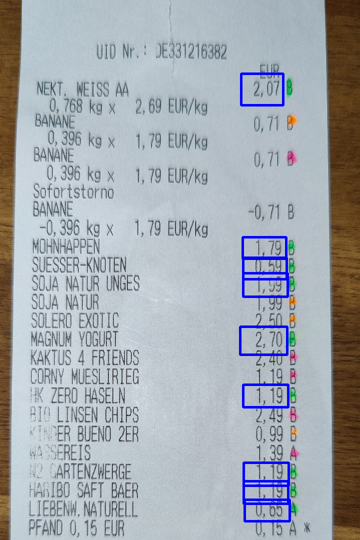

In [6]:
# Create a binary mask for the specified color
mask = cv2.inRange(hsv_image, lower, upper)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to store the regions inside bounding boxes
result_image = raw_image.copy()

boxs_coordinates = []
# Draw bounding rectangles around the detected contours
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # if all([w > 10, h > 10, h < 100]):
    ## TODO filter for small boxes
    # if all([w > 10, h > 10, h < 300]):
    # if all([w > 10, w < 300, h > 10, h < 300]):
    if all([w > 13, w < 40, h > 10, h < 44]):
        print(w, h)
        x -= 90
        y -= 7
        w += 70
        h += 20
        cv2.rectangle(result_image, ((x), y), ((x) + w, y + h), (255, 0, 0), 3)  # Green rectangle
        boxs_coordinates.append((x, y, x + w, y + h))
        # print(contour)
    else:
        pass

plot_results(result_image, scale=0.5)

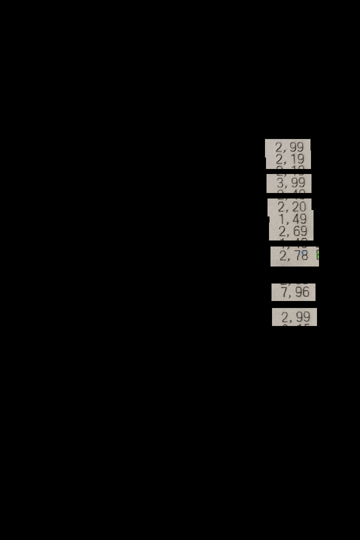

In [ ]:
# Create a black canvas with the same size as the original image
canvas = np.zeros_like(result_image)

image_snippets=[]
# Copy the regions inside bounding boxes to the canvas
for coordinates in boxs_coordinates:
    x1, y1, x2, y2 = coordinates
    canvas[y1:y2, x1:x2] = raw_image[y1:y2, x1:x2]
    image_snippets.append(raw_image[y1:y2, x1:x2])

image_snippets=image_snippets[::-1]

plot_results(canvas, "inline", 0.5)

In [ ]:
type(image_snippets[0])

numpy.ndarray

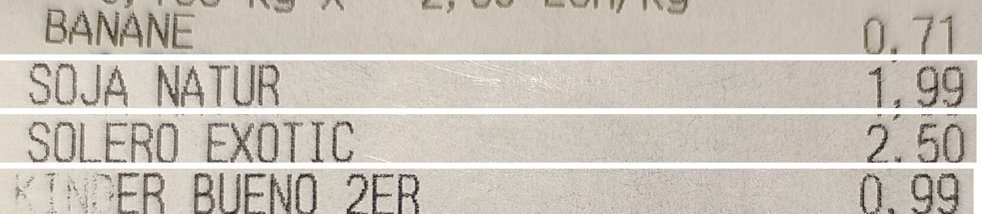

In [ ]:
# image = Image.fromarray(test[0])

# Define the dimensions of the canvas (you can adjust these as needed)
max_width = np.max([Image.fromarray(te).width for te in image_snippets])
total_height = np.sum([Image.fromarray(te).height for te in image_snippets])
canvas_width = max_width
canvas_height = total_height + 10 * len(image_snippets) - 10

# Create an empty canvas
canvas = Image.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

x_offset = 0
y_offset = 0
for te in image_snippets:
    image = Image.fromarray(te)

    # Paste the image onto the canvas at the calculated position
    canvas.paste(image, (x_offset, y_offset))

    # Calculate the position to paste the image in the center of the canvas
    # x_offset = (x_offset - image.width)
    y_offset = (y_offset + image.height + 10)



# Save or display the final canvas
# canvas.save('output_canvas.png')
plot_results(canvas, "popup")

canvas_array = np.array(canvas)

In [ ]:
_, image_bytes = cv2.imencode('.jpg', canvas_array)
image_data = image_bytes.tobytes()

In [ ]:
google_image = vision.Image(content=image_data)

In [ ]:
response = client.text_detection(image=google_image)
texts = response.text_annotations

In [ ]:
text = texts[0].description
text


'3\nBANANE\nSOJA NATUR\nSOLERO EXOTIC\nKINDER BUENO 2ER\n0.71\n1.99\n2.50\n0.99'

In [ ]:
len(text.split("\n"))

9

In [ ]:
text = text.replace(",", ".")
# text = text.replace(" ", "")
text

'3\nBANANE\nSOJA NATUR\nSOLERO EXOTIC\nKINDER BUENO 2ER\n0.71\n1.99\n2.50\n0.99'

In [ ]:
item_names = []
for item in text.split("\n"):
    try:
        float(item)
        break  # Stop the loop when a float is encountered
    except ValueError:
        if item.strip():  # Check if the string is not empty or doesn't contain only whitespace
            item_names.append(item)
item_names

[]

In [ ]:
item_prices = []
for item in text.split("\n"):
    item = item.replace(" ", "")
    try:
        float(item)
        if item.strip():  # Check if the string is not empty or doesn't contain only whitespace
            item_prices.append(float(item))
    except:
        pass
item_prices

[3.0, 0.71, 1.99, 2.5, 0.99]

In [ ]:
assert len(item_names) == len(item_prices), "The number of item names and item prices must be the same"

AssertionError: The number of item names and item prices must be the same

In [ ]:
pd.DataFrame({"item_name": item_names, "item_price": item_prices})

,item_name,item_price
0,BANANE,0.71
1,KAKTUS 4 FRIENDS,2.40
2,CORNY MUESLIRIEG,1.19
3,BIO LINSEN CHIPS,2.49
4,WASSEREIS,1.39


In [ ]:
## removing everything except numbers (0-9), decimal points (.), commas (,) and newlines (\n)
# number_string = re.sub(r'[^0-9.,\n]', '', text)
# print(number_string)

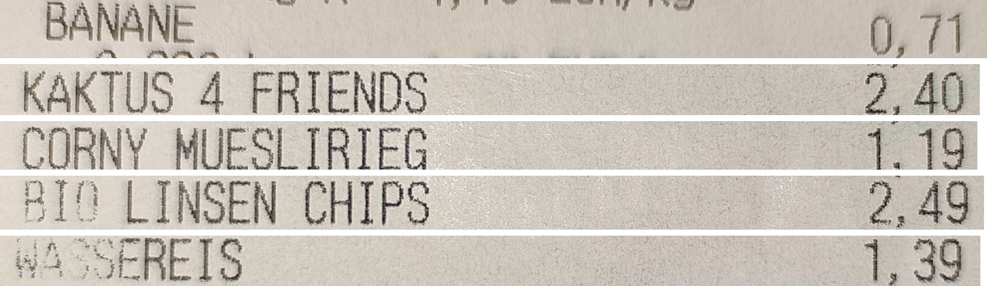

In [ ]:
plot_results(canvas, "popup")


In [ ]:
number_string_split = [val for val in number_string.split("\n") if len(val) > 0]
number_string_split

NameError: name 'number_string' is not defined

In [ ]:
## there are no double-digit amounts
# single_digits = [val if len(val.split(".")[0]) <= 1 else float(val[1:]) for val in number_string_split]
# single_digits

In [ ]:
numbers = [float(val) for val in number_string_split]
print(numbers)

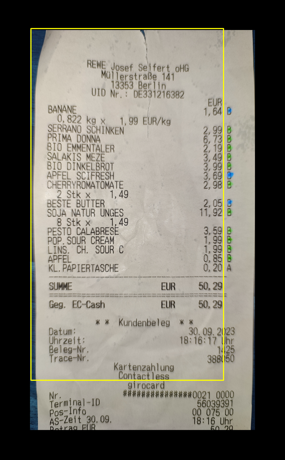

In [ ]:
# Load the image
image = raw_image.copy()

# Add a border to the image to create a buffer zone
border_thickness = 300  # Adjust this value as needed
image_with_border = cv2.copyMakeBorder(image, border_thickness, border_thickness, border_thickness, border_thickness, cv2.BORDER_CONSTANT, value=[0, 0, 0])


image_copy = image_with_border.copy()
# Convert the image to grayscale
# gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
gray = image_copy[:,:,0]
# Threshold the image to create a mask for white areas
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Apply morphological dilation to connect white regions
kernel = np.ones((15, 15), np.uint8)  # Adjust the kernel size as needed
dilated = cv2.dilate(thresh, kernel, iterations=4)

contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
# Get the bounding box coordinates
x, y, w, h = cv2.boundingRect(largest_contour)

# Draw a bounding box around the white area
cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 255, 0), 10)
# Display the image with bounding boxes
# cv2.imshow('Image with Bounding Boxes', raw_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plot_results(image_copy, scale=0.1)

# Optionally, save the image with bounding boxes
# cv2.imwrite('output_image.jpg', image)
